In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib.ticker import LinearLocator
from scipy.optimize import newton
from slicer_generation import *
from surface_solns import *

In [2]:
%matplotlib ipympl

In [4]:
npts=30
c = -1/10
k = 0

alpha=10
beta=-12
gamma=10
alpha = convert_angle(alpha) * np.pi/180
beta = convert_angle(beta) * np.pi/180
gamma = convert_angle(gamma) * np.pi/180

x0, y0 = conic_3d_off_axis_distance(c, alpha, beta)
y=-y0

dervx_eval = np.zeros(npts)
dervy_eval = np.zeros(npts)
xpts = np.linspace(-3,3,npts)
for i in range(npts):
    dervx_eval[i], dervy_eval[i], _ = conic_3d_surface_normal(xpts[i], y, c, k, alpha, beta, gamma, False)

-0.048738675609449486


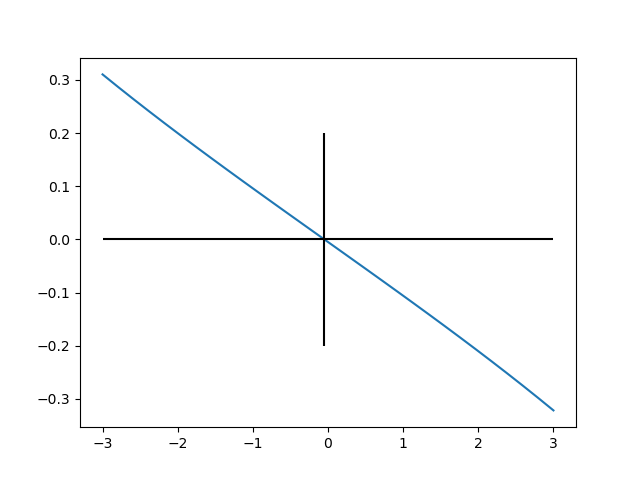

In [7]:
def conic_3d_dervx(x, y, c, k, alpha, beta, gamma, normalize=True):
    dervx, dervy, _ = conic_3d_surface_normal(x, y, c, k, alpha, beta, gamma, normalize=False)
    return dervx

result = newton(conic_3d_dervx, x0, tol=1e-13, args=(y, c, k, alpha, beta, gamma), full_output=True)
xroot = result[0]
print(xroot)

plt.figure()
plt.plot(xpts, dervx_eval)
plt.hlines(0, xpts[0], xpts[-1], colors='k')
plt.vlines(xroot, -0.2, 0.2, colors='k')
plt.show()

-0.04975124378109452 -1.012767638501193 -7.589224716516964
checking (2.0, 0.0)
t is -4.1748821258404645
result is -1.6500706328021175
-0.04975124378109452 -1.0745619902050514 -9.41775778063539
checking (1.0, 0.0)
t is -4.949169353859496
result is -0.8295836500825255
-0.04975124378109452 -1.1371170873802976 -11.469626854098507
checking (0.0, 0.0)
t is -5.772152267450571
result is 1.7763568394002505e-15
analytic soln: -5.772152267450571
numerical soln:-5.7955911823647295


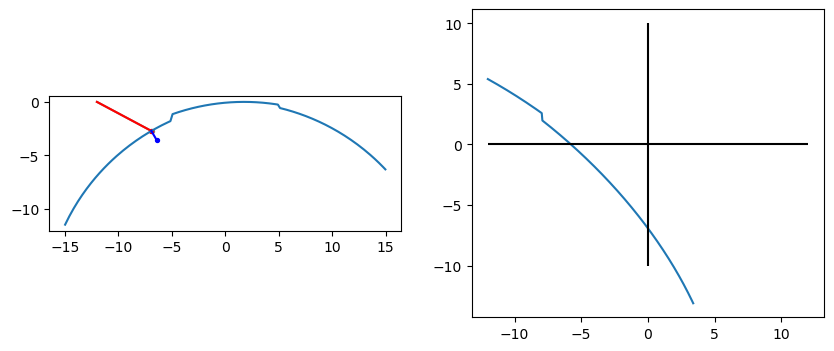

In [2]:
sag_func = tilted_plane_sag
surface_norm_func = tilted_plane_surface_normal
transfer_dist_func = tilted_plane_transfer
critical_xy_func = tilted_plane_critical_xy

sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal
transfer_dist_func = conic_3d_transfer
critical_xy_func = conic_3d_critical_xy


n_each = 1
n_rows = 1
n_cols = 3
mode = 1
trace_walls = True
active_x = False
active_y = False
dalpha = 0
dbeta = -8
dgamma = 5
alpha_cen = 0
beta_cen = 10
gamma_cen = 0
dx = 10
dy = 5
r = -20.1
c = 1/r
k = 0
xgap_width = 0
xgap_depth = -3
ygap_width = 0
ygap_depth = 2
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)

yt = 0
x = np.linspace(-20, 20, 200)
surf = np.zeros(len(x))
for i,x1 in enumerate(x):
    surf[i] = make_image_slicer(x1, yt, p, sag_func)


xt = -12
l = -1.5
m = 0
n = 0.8
norm = np.sqrt(l*l+m*m+n*n)
l /= norm
m /= norm
n /= norm

ray_in = RayIn(xt, yt, l, m, n)
ray_out = RayOut(0, 0, 0, 0, 0, 0, 0)

zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)
ray_out = ray_trace_slicer(ray_in, zmin, zmax, p, sag_func, transfer_dist_func, surface_norm_func)
print("analytic soln: " + str(ray_out.t))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_equation(t1, xt, yt, l, m, n, p, sag_func)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(x, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([ray_in.xt, ray_out.xs], [0, ray_out.zs], c='r', zorder=1)
axs[0].scatter([ray_out.xs], [ray_out.zs], c='r', s=8, zorder=1)
axs[0].plot([ray_out.xs, ray_out.xs + ray_out.ln], [ray_out.zs, ray_out.zs + ray_out.nn], c='b')
axs[0].scatter([ray_out.xs + ray_out.ln], [ray_out.zs + ray_out.nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([ray_in.xt, ray_in.xt + tnum*ray_in.l], [0, tnum*ray_in.n], c='gray', zorder=0)
axs[0].scatter([ray_in.xt + tnum*ray_in.l], [tnum*ray_in.n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

/Users/ellenlee/Documents/Zemax_dll/ifugen/python/surface_solns.py:65: RuntimeWarning: invalid value encountered in sqrt
  return np.where(bsol**2-4*asol*csol < 0, 0, 2*csol/(-bsol + sgn*np.sqrt(bsol*bsol - 4*asol*csol)))


-0.0398406374501992 -0.7164925510308211 -10.0505762880931
checking (1.0, 0.0)
t is -9.548711910445014
result is 0.7294885303966305
-0.0398406374501992 -0.7231363812647189 -10.0505762880931
checking (1.0, 1.0)
t is -9.365548911167613
result is 0.6871094668517583
-0.0398406374501992 -0.7268940251271877 -10.0505762880931
checking (1.0, 2.0)
t is -9.266620298332395
result is 0.6636269191122212
-0.0398406374501992 -0.7276513085109259 -10.0505762880931
checking (1.0, 3.0)
t is -9.247065044313908
result is 0.6589357888670174
-0.0398406374501992 -0.7253852217435222 -10.0505762880931
checking (1.0, 4.0)
t is -9.30595900430904
result is 0.6730145819685813
-0.0398406374501992 -0.586056184878206 -6.327707600187571
checking (1.0, 5.0)
t is -7.123249369740044
result is 0.05103028223660422
-0.0398406374501992 -0.5927000151121039 -6.327707600187571
checking (1.0, 6.0)
t is -6.971529323272526
result is 5.551115123125783e-16
analytic soln: -6.971529323272526
numerical soln:-6.949899799599199


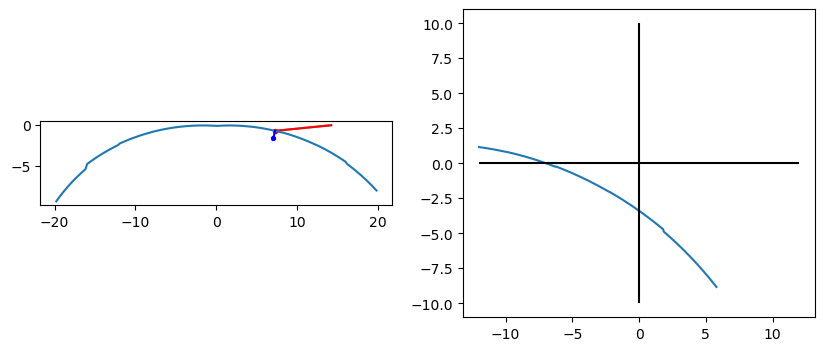

In [10]:
sag_func = tilted_plane_sag
surface_norm_func = tilted_plane_surface_normal
transfer_dist_func = tilted_plane_transfer
critical_xy_func = tilted_plane_critical_xy


sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal
transfer_dist_func = conic_3d_transfer
critical_xy_func = conic_3d_critical_xy


n_each = 5
n_rows = 2
n_cols = 3
mode = 1
trace_walls = True
active_x = False
active_y = False
dalpha = -15
dbeta = 15
dgamma = 10
alpha_cen = 0
beta_cen = 5
gamma_cen = -5
dx = 10
dy = 4
r = -25.1
c = 1/r
k = 0
xgap_width = 0
xgap_depth = 3
ygap_width = 0
ygap_depth = 2
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)

xt = 0
y = np.linspace(-20, 20, 200)
surf = np.zeros(len(y))
for i,y1 in enumerate(y):
    surf[i] = make_image_slicer(xt, y1, p, sag_func)


yt = 14.2
l = 0
m = 1
n = 0.1
norm = np.sqrt(l*l+m*m+n*n)
l /= norm
m /= norm
n /= norm

ray_in = RayIn(xt, yt, l, m, n)
ray_out = RayOut(0, 0, 0, 0, 0, 0, 0)

zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)
ray_out = ray_trace_slicer(ray_in, zmin, zmax, p, sag_func, transfer_dist_func, surface_norm_func)
print("analytic soln: " + str(ray_out.t))

t = np.linspace(-12, 12, 500)
feval = np.zeros(len(t))
for i,t1 in enumerate(t):
    feval[i] = transfer_equation(t1, xt, yt, l, m, n, p, sag_func)
idx = np.nanargmin(np.abs(feval))
tnum = t[idx]
print("numerical soln:" + str(tnum))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
axs[0].plot(y, surf)

# Draw analytically calculated ray and surface normal
axs[0].plot([ray_in.yt, ray_out.ys], [0, ray_out.zs], c='r', zorder=1)
axs[0].scatter([ray_out.ys], [ray_out.zs], c='r', s=8, zorder=1)
axs[0].plot([ray_out.ys, ray_out.ys + ray_out.mn], [ray_out.zs, ray_out.zs + ray_out.nn], c='b')
axs[0].scatter([ray_out.ys + ray_out.mn], [ray_out.zs + ray_out.nn], c='b', s=8, zorder=10)

# Numerically determined ray
axs[0].plot([ray_in.yt, ray_in.yt + tnum*ray_in.m], [0, tnum*ray_in.n], c='gray', zorder=0)
axs[0].scatter([ray_in.yt + tnum*ray_in.m], [tnum*ray_in.n], c='gray', s=8, zorder=0)

axs[0].set_aspect("equal")

axs[1].plot(t, feval)
axs[1].hlines(0, t[0], t[-1], colors='k')
axs[1].vlines(0, -10, 10, colors='k')
#axs[1].set_ylim(np.nanmin(feval), np.nanmax(feval))

plt.show()

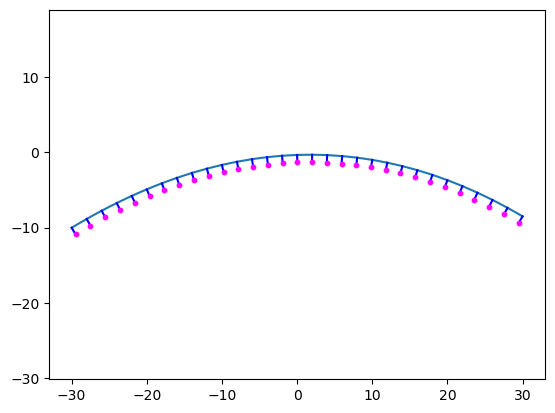

In [11]:
#sag_func = tilted_plane_sag
#surface_norm_func = tilted_plane_surface_normal
sag_func = conic_3d_sag
surface_norm_func = conic_3d_surface_normal

xs = np.linspace(-30,30,100)
r = 50
c = -1/r
k = -1
alpha = 11
beta = 10
gamma = 3

surface = sag_func(xs, y0, c, k, alpha, beta, gamma)

#print(conic_3d_sag_critical_x_y(c, k, 0, 2, gamma))


#idx = np.argmin(surface)
#print(xs[idx])

plt.figure()
plt.plot(xs, surface)

for xtest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(xtest, y0, c, k, alpha, beta, gamma)
    ztest = sag_func(xtest, y0, c, k, alpha, beta, gamma)
    plt.plot([xtest, xtest+nx], [ztest, ztest+nz], c='b')
    plt.scatter([xtest+nx], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
plt.plot()
plt.axis("equal")
#plt.plot([xtest, xtest-c*xtest], [ztest, ztest+1-c*ztest], c='r')
#plt.ylim(-1,4)
#plt.scatter(xs[idx], surface[idx], c='r')
plt.show()

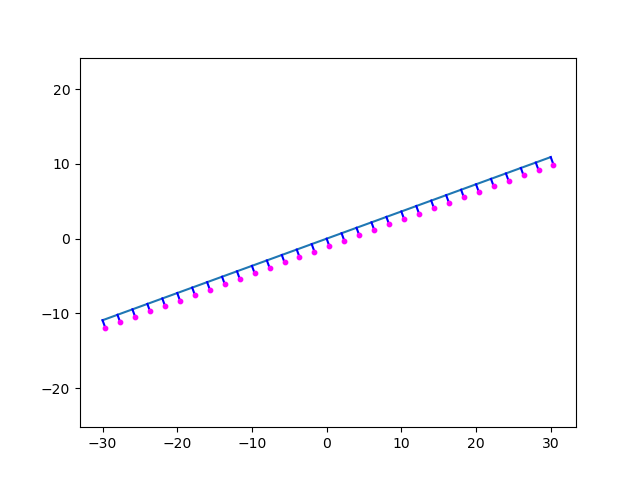

In [47]:
ys = np.linspace(-30,30,100)
x0 = 0

surface = sag_func(x0, ys, c, k, alpha, beta, gamma)

plt.figure()
plt.plot(ys, surface)

for ytest in np.arange(-30, 30.1, 2):
    nx, ny, nz = surface_norm_func(x0, ytest, c, k, alpha, beta, gamma)
    ztest = sag_func(x0, ytest, c, k, alpha, beta, gamma)
    plt.plot([ytest, ytest+ny], [ztest, ztest+nz], c='b')
    plt.scatter([ytest+ny], [ztest+nz], c='fuchsia', s=10, zorder=10)
    #plt.plot([ytest, ytest-c*ytest], [ztest, ztest+1-c*ztest], c='r'
plt.axis("equal")
plt.show()

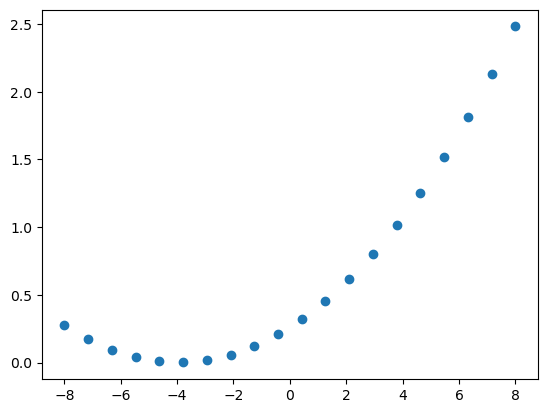

In [8]:
n_each = 1
n_rows = 1
n_cols = 1
mode = 0
trace_walls = True
active_x = False
active_y = False
dalpha = -0
dbeta = 0
dgamma = 0
alpha_cen = 0
beta_cen = 15
gamma_cen = 0
dx = 15
dy = 5
r = 30
c = 1/r
k = -1
gx_width = 0
gx_depth = np.nan
gy_width = 0
gy_depth = np.nan
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_walls, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, gx_width, gx_depth, gy_width, gy_depth)

N = 20
r = 20
k = 0
t = -10

y = np.linspace(-8, 8, N)
x = np.linspace(-8, 8, N)
z = conic_3d_sag(x, 0, c, k, alpha_cen, beta_cen, 0)

plt.figure()
plt.scatter(x, z)
plt.show()

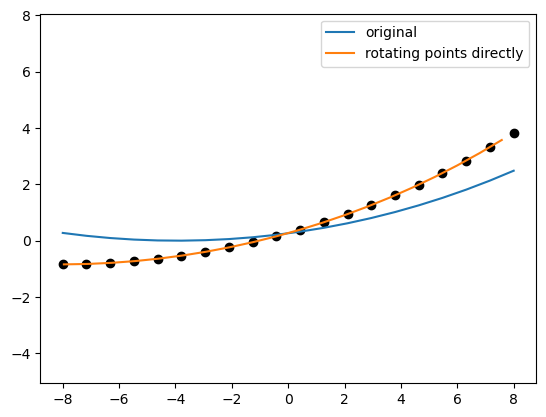

In [10]:
beta_cen= 15
t=-8
def conic(x,c,k,beta):
    beta *= np.pi/180
    x0 = np.sin(beta) / c / (1 + np.cos(beta))
    x += x0
    return c*x*x / (1 + np.sqrt(1-(1+k)*c*c*x*x))

N = 20

# perform the rotation manually with a rotation matrix
x1 = np.linspace(-8, 8, N)
y1 = []
x2 = []
y2 = []
#y3 = []
trad = -t*np.pi/180

for i in range(N):
    y1.append(conic(x1[i],c,k,beta_cen))
    xnew = x1[i]*np.cos(trad)-y1[i]*np.sin(trad)
    ynew = x1[i]*np.sin(trad)+y1[i]*np.cos(trad)
    x2.append(xnew)
    y2.append(ynew)
    #y3.append(rotated_conic(x1[i], r, k, t))

y3 = conic_3d_sag(x1, 0, c, k, alpha_cen, beta_cen, t)
plt.figure()
plt.plot(x1,y1,label='original')
plt.plot(x2,y2,label='rotating points directly')
plt.scatter(x1,y3,c='k')
#plt.vlines([-2,0,2], -1, 1)
#plt.ylim(0,8)
#plt.xlim(-8,8)
plt.axis('equal')
plt.legend()
#plt.savefig("rotated_conics.png",dpi=300,facecolor="white")
plt.show()

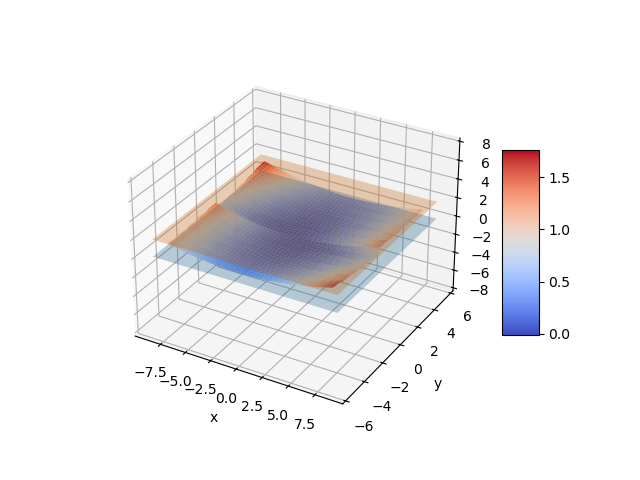

In [8]:
sag_func = tilted_plane_sag
sag_func = conic_3d_sag
critical_xy_func = conic_3d_critical_xy

n_each = 5
n_rows = 2
n_cols = 2
mode = 1
trace_gaps = False
active_x = False
active_y = False
dalpha = 3
dbeta = 2
dgamma = 1
alpha_cen = 0
beta_cen = 0
gamma_cen = 0
dx = 8
dy = 1
r = 30
c = 1/r
k = 0
xgap_width = 0
xgap_depth = -0.5
ygap_width = 0
ygap_depth = -0.8
p = ImageSlicerParams(n_each, n_rows, n_cols, mode, trace_gaps, active_x, active_y, dalpha, dbeta, dgamma, alpha_cen, beta_cen, gamma_cen, dx, dy, c, k, xgap_width, xgap_depth, ygap_width, ygap_depth)
xsize, ysize = get_slicer_size(p)

N = 200

#Nx = n_cols * 8
#Ny = n_rows * n_each * 8
x = np.linspace(-1.1*xsize/2,1.1*xsize/2,N)
y = np.linspace(-1.1*ysize/2,1.1*ysize/2,N)

Z = np.zeros((N,N))
for i,x1 in enumerate(x):
    for j,y1 in enumerate(y):
        Z[j,i]=make_image_slicer(x1, y1, p, sag_func)
        #Z[i,j]=make_image_slicer2(x1, y1, n_each, dalpha, dbeta, alpha_cen, beta_cen, dx, dy, rx, ry, kx, ky)
    

X, Y = np.meshgrid(x, y)
#Z2 = make_slice(X, Y, rx, ry, kx, ky, 0, 0)

zmin, zmax = find_global_extrema_slicer(p, sag_func, critical_xy_func)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
ax.plot_surface(X,Y,np.ones((N,N))*zmin, alpha=0.3)
ax.plot_surface(X,Y,np.ones((N,N))*zmax, alpha=0.3)
#ax.scatter(9.487179487179485,-4.364548494983277,-0.6999614810235664, c='g')
#ax.scatter(9.487179487179485,14.899665551839465,3.8157755724491054, c='g')
#surf = ax.plot_surface(X, Y, Z2, cmap=cm.viridis)
#ax.zaxis.set_major_formatter('{x:.02f}')
#ax.view_init(azim=90, elev=0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlim(-8, 8)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()